In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [20]:
# 🔹 Définition des chemins
train_dir = "../data/train"
test_dir = "../data/test"

# 🔹 Classes (sans `disgust`)
CLASS_NAMES = ["angry", "fear", "happy", "neutral", "sad", "surprise"]
NUM_CLASSES = len(CLASS_NAMES)

# 🔹 Paramètres
IMG_SIZE = (48, 48)
BATCH_SIZE = 32

# 🔹 Data augmentation spécifique par classe
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 🔹 Chargement des images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    classes=CLASS_NAMES  # Forcer à ne charger que ces classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=CLASS_NAMES  # Forcer à ne charger que ces classes
)

# 🔹 Adapter grayscale en RGB pour EfficientNet
input_layer = Input(shape=(48, 48, 1))

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [21]:
print("Classes chargées :", train_generator.class_indices)


Classes chargées : {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}


In [22]:
def preprocess_for_efficientnet(x):
    x = tf.image.grayscale_to_rgb(x)  # Convertir en 3 canaux
    x = tf.image.resize(x, (224, 224))  # Redimensionner pour EfficientNet
    return x

x = tf.keras.layers.Lambda(preprocess_for_efficientnet)(input_layer)

# 🔹 Charger EfficientNetB0 (sans classifier)
base_model = EfficientNetB0(weights="imagenet", include_top=False)
x = base_model(x, training=False)  # Ne pas entraîner les couches de base

# 🔹 Ajouter les nouvelles couches
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation="softmax")(x)

# 🔹 Création du modèle
model = Model(inputs=input_layer, outputs=output_layer)

# 🔹 Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# 🔹 Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)

# 🔹 Entraînement (Phase 1 : modèle gelé)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
884/884 [==============================] - 76s 81ms/step - loss: 1.7476 - accuracy: 0.2532 - val_loss: 17.2438 - val_accuracy: 0.2510 - lr: 1.0000e-04
Epoch 2/15
884/884 [==============================] - 71s 80ms/step - loss: 1.7313 - accuracy: 0.2627 - val_loss: 30.1913 - val_accuracy: 0.1765 - lr: 1.0000e-04
Epoch 3/15
884/884 [==============================] - 70s 80ms/step - loss: 1.7209 - accuracy: 0.2702 - val_loss: 27.5488 - val_accuracy: 0.1765 - lr: 1.0000e-04
Epoch 4/15
884/884 [==============================] - ETA: 0s - loss: 1.7063 - accuracy: 0.2823
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
884/884 [==============================] - 71s 80ms/step - loss: 1.7063 - accuracy: 0.2823 - val_loss: 33.1069 - val_accuracy: 0.1745 - lr: 1.0000e-04
Epoch 5/15
884/884 [==============================] - 71s 80ms/step - loss: 1.6788 - accuracy: 0.2966 - val_loss: 9.0239 - val_accuracy: 0.2510 - lr: 2.0000e-05
Epoch 6/15
884/884 [=========

In [ ]:
# 🔹 Fine-Tuning (Dé-geler EfficientNet)
base_model.trainable = True
for layer in base_model.layers[:100]:  # Geler les 100 premières couches seulement
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

221/221 [==============================] - 4s 20ms/step - loss: 1.5333 - accuracy: 0.3781
Test Accuracy: 0.38


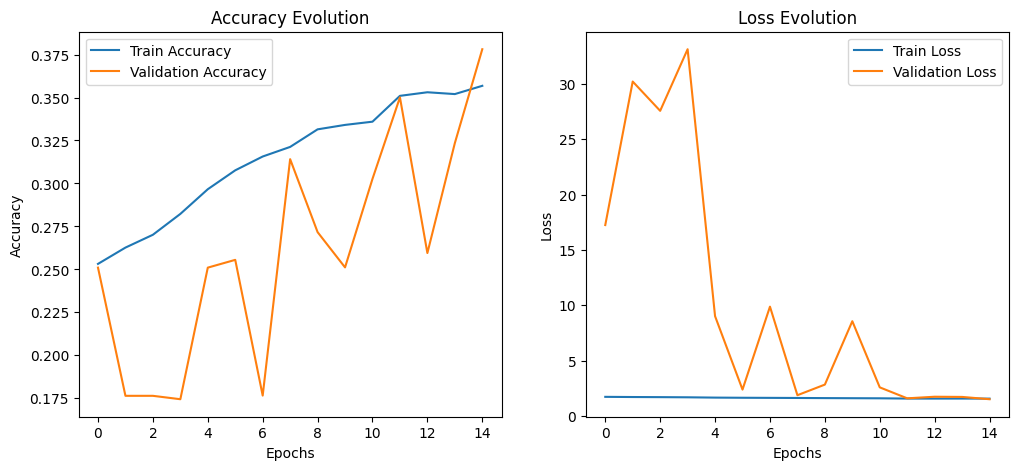

In [23]:
# 🔹 Évaluation finale
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# 🔹 Visualisation des performances
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history["accuracy"], label="Train Accuracy")
    ax[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    ax[0].set_title("Accuracy Evolution")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()

    ax[1].plot(history.history["loss"], label="Train Loss")
    ax[1].plot(history.history["val_loss"], label="Validation Loss")
    ax[1].set_title("Loss Evolution")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()

    plt.show()

plot_history(history)

1/1 [==============================] - 1s 665ms/step


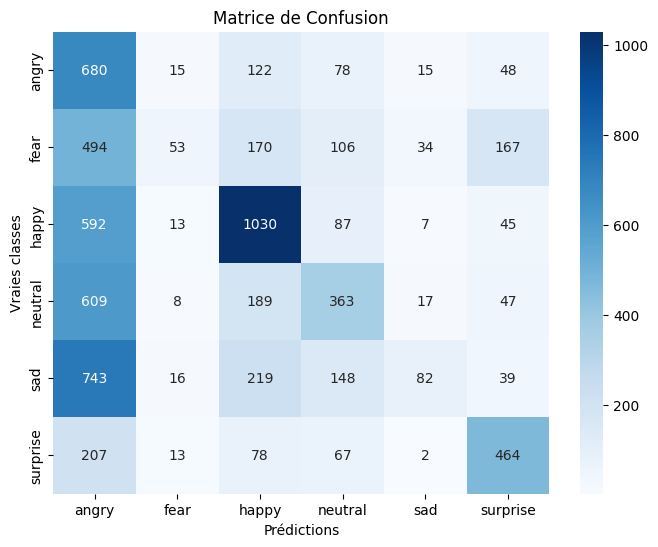

Classification Report:
              precision    recall  f1-score   support

       angry       0.20      0.71      0.32       958
        fear       0.45      0.05      0.09      1024
       happy       0.57      0.58      0.58      1774
     neutral       0.43      0.29      0.35      1233
         sad       0.52      0.07      0.12      1247
    surprise       0.57      0.56      0.57       831

    accuracy                           0.38      7067
   macro avg       0.46      0.38      0.34      7067
weighted avg       0.47      0.38      0.35      7067



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Récupérer les vraies étiquettes et prédictions
y_true = []
y_pred = []

for batch in test_generator:
    X_batch, y_batch = batch
    y_true.extend(np.argmax(y_batch, axis=1))  # Labels réels
    y_pred.extend(np.argmax(model.predict(X_batch), axis=1))  # Prédictions

    if len(y_true) >= test_generator.samples:
        break  # Stopper quand on a toutes les prédictions

# Obtenir les noms des classes
class_labels = list(test_generator.class_indices.keys())

# 🔹 Générer la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# 🔹 Affichage avec seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion")
plt.show()

# 🔹 Rapport détaillé des performances
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
